## Get incoming velocity to inform MITgcm body forcing

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import scipy.io as sio

In [2]:
idalia_land = '#8b7765'
def rotate(x_comp, y_comp, angle):
    '''Input:
        x_comp:: x component of vector
        y_comp:: y component of vector
       angle:: in radians.
       Returns:
       Rotated componets of vector x_rot and y_rot'''
    x_rot = x_comp*np.cos(angle)-(y_comp)*np.sin(angle)
    y_rot = x_comp*np.sin(angle)+(y_comp)*np.cos(angle)
    return(x_rot, y_rot)

def trans_polar(r,th,r0,th0):
    rprime = (r**2+r0**2+2*r*r0*np.cos(th0-th))**0.5
    thprime = np.arccos((r*np.cos(th)+r0*np.cos(th0))/rprime)
    return(rprime,thprime)

def get_field(varname, filepath):
    '''
    file:: str, path to file
    name:: str, variable name (eg 'typevector_filtered', 'velocity_magnitude', 'x','y','u_filtered', 'v_filtered', etc.)
    '''
    mat = sio.loadmat(filepath, squeeze_me=True)
    var = mat[varname]
    return(var)

def get_mask(filepath, fr=0):
    '''Get the mask from a PIV mat file.'''
    mat = sio.loadmat(filepath, squeeze_me=True)
    mask_PIV = np.ma.masked_values(mat['typevector_filtered'][0],0)
    mask = np.ma.getmask(mask_PIV)
    return(mask)

def get_insert_bathy(angle, H = 0.092):
    ''' Get the bathymetry of the canyon insert and x,y coordinates rotated by an angle
    
    INPUT
    angle:: float, angle in radians, positive angle rotates counterclockwise
    H:: float, max depth of water column in meters
    
    RETURNS
    xIns_rot, yIns_rot, x and y coordinates rotated by angle (2D arrays)
    depth_ins, 2D array with depth values'''
    
    insert_file = '/ocean/kramosmu/Building_canyon/BuildCanyon/Bathymetry/tank/BathyInsert03.nc'
    H = 0.092 # m, max water level

    with Dataset(insert_file, 'r') as nbl:
        Xins = nbl.variables['X'][:]
        Yins = nbl.variables['Y'][:]
        depth_ins = (nbl.variables['Bathymetry'][:])-H

    xIns_rot = Xins*np.cos(angle)-(Yins)*np.sin(angle)
    yIns_rot = Xins*np.sin(angle)+(Yins)*np.cos(angle)
    return(xIns_rot, yIns_rot, depth_ins)

def get_plot_data(fr, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr,y,x)
    x_ma = 100*np.ma.masked_array(x[fr], mask=mask)
    y_ma = 100*np.ma.masked_array(y[fr], mask=mask)
    u_ma = 100*np.ma.masked_array(u[fr], mask=mask)
    v_ma = 100*np.ma.masked_array(v[fr], mask=mask)
    spd_ma =100* np.ma.masked_array(spd[fr],mask=mask)

    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def get_plot_data_mean(fr_slice, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr_slice,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr_slice,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr_slice,y,x)
     
    x_ma = 100*np.ma.masked_array(np.mean(x[fr_slice],0), mask=mask)
    y_ma = 100*np.ma.masked_array(np.mean(y[fr_slice],0), mask=mask)
    u_ma = 100*np.ma.masked_array(np.mean(u[fr_slice],0), mask=mask)
    v_ma = 100*np.ma.masked_array(np.mean(v[fr_slice],0), mask=mask)
    spd_ma =100*np.ma.masked_array(np.mean(spd[fr_slice],0),mask=mask)
    
    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

In [3]:
# Set file paths
filepath1 = '../exp_01aug19/frames/run01/T02_run01_PIV.mat'
filepath2 = '../exp_01aug19/frames/run02/T02_run02_piv.mat'
filepath3 = '../exp_01aug19/frames/run03/T01_run03_PIV.mat'

In [4]:
# get masks variables shape is (fr,y,x)

mask1 = get_mask(filepath1) # (y,x)
mask2 = get_mask(filepath2) # (y,x)
mask3 = get_mask(filepath3) # (y,x)

In [5]:
angle = (-15)*np.pi/180  # rot angle piv output

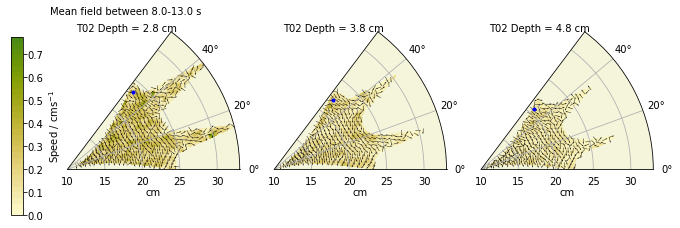

In [6]:
# normalized quiver
max_spd = 1.4
min_spd = 0
cbar_ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]

nt = 25
for fr in range(40,60,nt):#600,nt):
    fig = plt.figure(figsize=(10.5,4.5))
    ax0 = fig.add_subplot(131, projection='polar')
    ax1 = fig.add_subplot(132, projection='polar')
    ax2 = fig.add_subplot(133, projection='polar')
   
    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    ax2.set_facecolor('beige')
    
    #frame data
    x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
    x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
    x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)
    
    r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
    th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)
    
    r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
    th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
    ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)
    
    r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
    th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
    ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
    uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)
   
    # plot data 1
    cf = ax0.contourf(th1,r1,spd_ma1,30,
                      cmap=cmo.cm.speed, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    cbar_ax = fig.add_axes([0.05, 0.15, 0.016, 0.55])
    cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.set_label('Speed / cms$^{-1}$')
    
    qv = ax0.quiver(th1[::2,::2],r1[::2,::2],
                    U1[::2,::2],V1[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    station = ax0.plot(th1[18,2],r1[18,2],'bo', markersize=3)

    # plot data 2
    cf = ax1.contourf(th2,r2,spd_ma2,30,
                      cmap=cmo.cm.speed, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    
    qv = ax1.quiver(th2[::2,::2],r2[::2,::2],
                    U2[::2,::2],V2[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    station = ax1.plot(th2[20,2],r2[20,2],'bo', markersize=3)

    # plot data 3
    cf = ax2.contourf(th3,r3,spd_ma3,30,
                      cmap=cmo.cm.speed, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    
    qv = ax2.quiver(th3[::2,::2],r3[::2,::2],
                    U3[::2,::2],V3[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    station = ax2.plot(th3[14,1],r3[14,1],'bo', markersize=3)

    ax0.text(0.05,.9,'T02 Depth = 2.8 cm',transform=ax0.transAxes)
    ax1.text(0.05,.9,'T02 Depth = 3.8 cm',transform=ax1.transAxes)
    ax2.text(0.05,.9,'T02 Depth = 4.8 cm',transform=ax2.transAxes)
    ax0.text(-0.1,1,'Mean field between %1.1f-%1.1f s' %(fr/5,(fr+nt)/5), 
             transform=ax0.transAxes)
    ax0.set_xlabel('cm', labelpad=0.0)
    ax1.set_xlabel('cm', labelpad=0.0)
    ax2.set_xlabel('cm', labelpad=0.0)
    ax0.set_rlim(10,33)
    ax1.set_rlim(10,33)
    ax2.set_rlim(10,33)    
    ax0.set_thetalim(0*np.pi/180,53*np.pi/180)
    ax1.set_thetalim(0*np.pi/180,53*np.pi/180)
    ax2.set_thetalim(0*np.pi/180,53*np.pi/180)
    ax0.set_aspect(1)


In [7]:
# Get ur and uth at stations
nt = 2
frames = np.arange(0,600,nt)
r_vel_1 = np.zeros(np.shape(frames))
r_vel_2 = np.zeros(np.shape(frames))
r_vel_3 = np.zeros(np.shape(frames))

th_vel_1 = np.zeros(np.shape(frames))
th_vel_2 = np.zeros(np.shape(frames))
th_vel_3 = np.zeros(np.shape(frames))

ii=0
for fr in frames:#600,nt):
    
    #frame data
    x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
    x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
    x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)
    
    r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
    th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)
    
    r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
    th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
    ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)
    
    r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
    th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
    ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
    uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)
   
    # data st 1
    r_vel_1[ii] = np.mean(ur1[17:19,2:4])
    th_vel_1[ii] = r1[18,2]*np.mean(uth1[17:19,2:4])
    r_st1 = r1[18,2]
    th_st1 = th1[18,2]
    
    # data st 2
    r_vel_2[ii] = np.mean(ur2[19:21,2:4])
    th_vel_2[ii] = r2[20,2]*np.mean(uth2[19:21,2:4])
    r_st2 = r2[20,2]
    th_st2 = th2[20,2]
    
    # data st 3
    r_vel_3[ii] = np.mean(ur3[13:15,2:4])
    th_vel_3[ii] = r3[14,2]*np.mean(uth3[13:15,2:4])
    r_st3 = r3[14,2]
    th_st3 = th3[14,2]
   
    print(fr,r_vel_1[ii],th_vel_1[ii],r_vel_2[ii],th_vel_2[ii],r_vel_3[ii],th_vel_3[ii])
    ii=ii+1

0 0.019518807914460746 -0.007132231454364602 -0.051808643813182426 0.007435436136992314 0.005204181951586846 -5.1213603261522285e-05
2 -0.005226006646113379 -0.04358598286963432 0.018770258341415613 0.03522709101675661 0.00490374350464992 0.005616239510627729
4 0.01779861393037698 -0.07177612015112998 0.015804381982675003 0.0033582858188723128 -0.00043800079390275476 -0.006429790246133664
6 0.03117875378100396 -0.1123433554173114 0.014418805572341636 0.0306834584336944 0.029220259804157985 -0.014708945533895321
8 0.024567655276064162 -0.11395642910474692 0.09863485239260689 -0.08807763155730534 -0.01005923748963836 -0.037112800581695096
10 -0.009416348767999953 -0.08570774673204613 -0.005368469821905131 -0.044445858361076424 0.030289258969635503 -0.029880355594911052
12 0.028351739423272224 -0.09183536877662767 0.058368001331263575 -0.05223411872500167 -0.02559591873785672 -0.07452844628035431
14 -0.004393151692361236 -0.18372137092488267 0.013575842686753721 -0.05476628426330829 -0.00

130 -0.08643810701504462 -0.4779660743635702 -0.036209968459825534 -0.6205696677199534 0.026461159902150082 -0.4863534206618302
132 0.052675649953495815 -0.5260215196341377 0.018554680600510298 -0.46652579866049915 0.04376748396752338 -0.4499205521749637
134 0.10957384666853266 -0.4622021655259194 0.020415976936445077 -0.3192485210824227 0.07665330243196974 -0.5069404649205331
136 0.05971958138407227 -0.5775509492766188 -0.03266052006777471 -0.39706344006706207 0.12305607631193996 -0.5281187439022147
138 0.05606209150957259 -0.33029901635749304 0.09483025347489749 -0.4906780469045427 0.011624539384960685 -0.40866478011518603
140 -0.02013270900717245 -0.49235269536961784 0.0910539616006841 -0.6547438971205191 0.017792486122661957 -0.30486695938428715
142 -0.042743123809618394 -0.3129629944996144 0.050045226472784116 -0.39715669638197004 -0.010638332593158127 -0.3983633622767289
144 -0.058485188060934536 -0.27161954123195575 -0.05193533827104912 -0.446594627225996 -0.044889453573354755 -

260 -0.044535200661561455 0.10301595115434735 -0.0086166001677918 -0.31126359249928565 -0.025890766570228912 -0.3011355192546211
262 -0.026536895499563614 0.014068833421040082 -0.014065642865194398 -0.45416719059580435 -0.003090035649372082 -0.38277563497171196
264 0.08528985533415269 -0.32633332347506394 0.06885782444844805 -0.49943403799335956 0.006337744316474405 -0.28380898073759564
266 -0.025504252984946407 -0.47639394760308806 -0.030923058915487606 -0.6819060867777748 0.008872273570488573 -0.30572751814442
268 0.05415879216699222 -0.48792105785190554 0.007537074687708076 -0.5897569953693428 0.08048814442503793 -0.20890910366579862
270 -0.06406659239912713 -0.6396298082685308 0.04189530438475046 -0.431614672677035 0.10382722647939023 -0.34669763655175595
272 0.10994704425091127 -0.3979528318237929 -0.09155649810198802 -0.47613221302298886 -0.024615721315495963 -0.343562034116467
274 0.05365768619953104 -0.27710646457580085 0.10017675571971654 -0.42658113142716464 0.016255684574918

390 0.029569386315867897 -0.41452563334023235 -0.08531173953328053 -0.18799010953092046 -0.015349247983755261 -0.38644961388039073
392 0.19408004097726989 -0.45869653065205285 0.01834235996191989 -0.39330579085969186 0.049703096186523056 -0.3249551801957975
394 -0.01995808789808778 -0.37535721485678764 -0.02953851716723674 -0.2528371305868769 -0.05904730001817931 -0.395758740408234
396 0.0370524010637088 -0.268831640304038 0.010264172574803557 -0.26165506659556337 -0.015527425939594282 -0.38360905234284387
398 -0.06691557888316749 -0.19947024102595234 -0.08380194389169197 -0.26546926547466626 -0.052452703646082045 -0.34424503053395517
400 0.06557683486344294 -0.17532156589949036 0.011040746075203972 -0.30301495042192944 -0.09448161862877423 -0.3192133641343077
402 -0.009072241625107596 -0.05262100262993247 0.014466753353560263 -0.4235900812843846 0.028246450470624844 -0.33484076689004494
404 0.00396796368182591 -0.05728417746802539 -0.0035663994005221897 -0.4040775768256559 -0.00104539

518 0.0169622110628599 -0.23331301439267568 -0.005127351218255619 -0.1622903923773019 0.04057738637951838 -0.3277541960077315
520 0.08387671651010707 -0.35923771907739244 0.05954755444636718 -0.1743027902067859 0.030213919240892707 -0.22687559288654163
522 0.017163442038008733 -0.21118721809378313 0.019209149404490918 -0.16892313441641502 0.02385643275746277 -0.25184315578445665
524 0.10500548552643643 -0.40032463511139826 0.027639902817474055 -0.21070016383181692 0.012070994207452616 -0.2891627360924813
526 0.04728529155723534 -0.11114111349937834 0.06429089941841934 -0.19242685363965373 0.025178479559001224 -0.25252994733002476
528 -0.05222180436905976 -0.0675649651751377 -0.003587747677363244 -0.1685267138436056 0.027158705352428415 -0.2333112610030397
530 -0.024742102301213733 0.040309240555871526 -0.05279459671748021 -0.10775163456790267 -0.08100596132736035 -0.3239281914821209
532 0.09409622007343507 -0.11388259549662169 0.00219334123301489 -0.14596910150047598 0.0195137953577598

Text(0.5,1,'Velocity at upstream slope stations (Exp T02)')

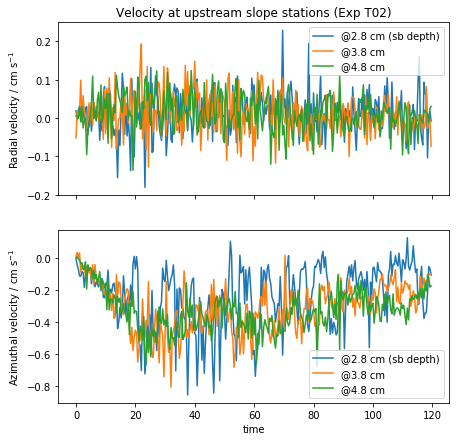

In [8]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(7,7), sharex=True)

times = frames/5
ax0.plot(times,r_vel_1,label='@2.8 cm (sb depth)')
ax0.plot(times,r_vel_2,label='@3.8 cm')
ax0.plot(times,r_vel_3,label='@4.8 cm')

ax1.plot(times,th_vel_1,label='@2.8 cm (sb depth)')
ax1.plot(times,th_vel_2,label='@3.8 cm ')
ax1.plot(times,th_vel_3,label='@4.8 cm ')

ax1.set_xlabel('time')
ax0.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')

ax0.legend()
ax1.legend()
ax0.set_title('Velocity at upstream slope stations (Exp T02)')

Text(0.5,1,'Magnitude of azimuthal velocity at upstream slope stations (Exp T02)')

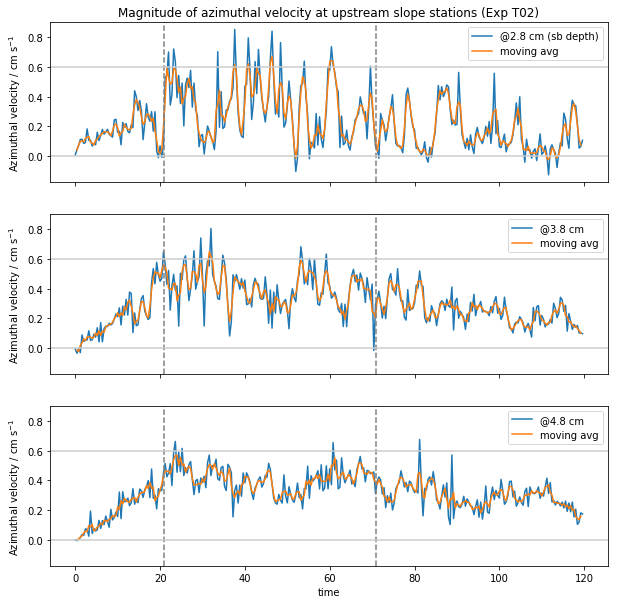

In [15]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

times = frames/5

ma_th_vel_1 = (th_vel_1[2:]+th_vel_1[1:-1]+th_vel_1[0:-2])/3
ma_th_vel_2 = (th_vel_2[2:]+th_vel_2[1:-1]+th_vel_2[0:-2])/3
ma_th_vel_3 = (th_vel_3[2:]+th_vel_3[1:-1]+th_vel_3[0:-2])/3

ax0.plot(times,-th_vel_1,label='@2.8 cm (sb depth)')
ax0.plot(times[1:-1],-ma_th_vel_1,label='moving avg')

ax1.plot(times,-th_vel_2,label='@3.8 cm ')
ax1.plot(times[1:-1],-ma_th_vel_2,label='moving avg')

ax2.plot(times,-th_vel_3,label='@4.8 cm ')
ax2.plot(times[1:-1],-ma_th_vel_3,label='moving avg')

ax2.set_xlabel('time')
ax0.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')

for ax in [ax0,ax1,ax2]:
    ax.legend()
    ax.axvline(21, color='0.5', linestyle='--')
    ax.axvline(71, color='0.5', linestyle='--')
    ax.axhline(0,color='0.8')
    ax.axhline(0.6,color='0.8')
ax0.set_title('Magnitude of azimuthal velocity at upstream slope stations (Exp T02)')

Text(0.5,1,'Radial velocity at upstream slope stations (Exp T02)')

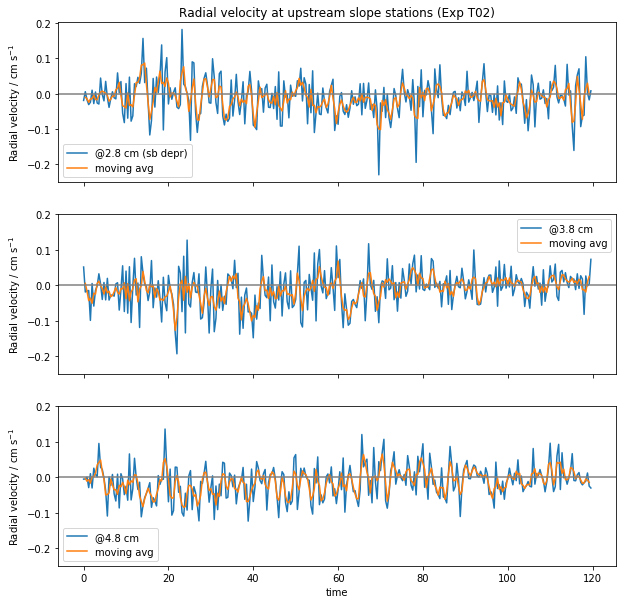

In [14]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

times = frames/5

ma_r_vel_1 = (r_vel_1[2:]+r_vel_1[1:-1]+r_vel_1[0:-2])/3
ma_r_vel_2 = (r_vel_2[2:]+r_vel_2[1:-1]+r_vel_2[0:-2])/3
ma_r_vel_3 = (r_vel_3[2:]+r_vel_3[1:-1]+r_vel_3[0:-2])/3

ax0.plot(times,-r_vel_1,label='@2.8 cm (sb depr)')
ax0.plot(times[1:-1],-ma_r_vel_1,label='moving avg')

ax1.plot(times,-r_vel_2,label='@3.8 cm ')
ax1.plot(times[1:-1],-ma_r_vel_2,label='moving avg')

ax2.plot(times,-r_vel_3,label='@4.8 cm ')
ax2.plot(times[1:-1],-ma_r_vel_3,label='moving avg')

ax2.set_xlabel('time')
ax0.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Radial velocity / cm s$^{-1}$')

for ax in [ax0,ax1,ax2]:
    ax.legend()
    ax.axhline(0, color='0.5',linestyle='-')
ax0.set_title('Radial velocity at upstream slope stations (Exp T02)')